In [54]:
library(data.table)
library(TSrepr)
library(TSdist)
library(dtw)
library(TunePareto)
library(dplyr)

# Summary

Yorum yap

# Context
(In order to get specified techniques rapidly, a context part is added to Notebook.)

1. [Data Preparation](#1)
1. [Classify Function](#2)
1. [Distances](#3)
1. [Representations](#4)
    1. [Difference Function](#5)
    1. [Difference Function](#6)
    1. [PAA](#7)
    1. [PAA Function](#8)
1. [Hyperparameter Selection](#9)
1. [Result of Models](#10)
1. [Test Performance](#11)
1. [Comments](#12)

<a id="1"></a>
# Data Preparation

In [2]:
dataset_path="D:/Datasets/Univariate2018_arff/Univariate_arff/"

In [3]:
distance_path="C:/Users/bahad/GitHub/IE48B/Homework3/Distances/"

In [4]:
first_dataset="Beef"
second_dataset="BirdChicken"
third_dataset="BMW"
fourth_dataset="Coffee"
fifth_dataset="Wine"

<a id="2"></a>
# Classify Function

In [6]:
nn_classify_cv=function(dist_matrix,train_class,test_indices,k){
    
    test_distances_to_train=dist_matrix[test_indices,]
    test_distances_to_train=test_distances_to_train[,-test_indices]
    train_class=train_class[-test_indices]

    ordered_indices=apply(test_distances_to_train,1,order)
    if(k==1){
        nearest_class=as.numeric(train_class[as.numeric(ordered_indices[1,])])
        nearest_class=data.table(id=test_indices,nearest_class)
    } else {
        nearest_class=apply(ordered_indices[1:k,],2,function(x) {train_class[x]})
        nearest_class=data.table(id=test_indices,t(nearest_class))
    }
    
    long_nn_class=melt(nearest_class,'id')

    class_counts=long_nn_class[,.N,list(id,value)]
    class_counts[,predicted_prob:=N/k]
    wide_class_prob_predictions=dcast(class_counts,id~value,value.var='predicted_prob')
    wide_class_prob_predictions[is.na(wide_class_prob_predictions)]=0
    class_predictions=class_counts[,list(predicted=value[which.max(N)]),by=list(id)]
    
    
    return(list(prediction=class_predictions,prob_estimates=wide_class_prob_predictions))
    
}

Classify function is obtained from lecture notebooks.

In [7]:
traindata=as.matrix(fread(sprintf('%s%s/%s_TRAIN.txt',dataset_path, first_dataset,first_dataset)))

In [8]:
str(traindata)

 num [1:30, 1:471] 1 1 1 1 1 1 2 2 2 2 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:471] "V1" "V2" "V3" "V4" ...


In [9]:
head(traindata)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V462,V463,V464,V465,V466,V467,V468,V469,V470,V471
1,-0.3629225,-0.36532777,-0.3878120,-0.40559023,-0.39900183,-0.36658270,-0.32454241,-0.31732654,-0.326529390,...,-1.85263380,-1.84928730,-1.84939180,-1.87626840,-1.8804515,-1.85817640,-1.84468580,-1.8362150,-1.84008440,-1.86110460
1,-0.1162805,-0.11642809,-0.1054315,-0.08978528,-0.06517204,-0.05081739,-0.03952556,-0.02638866,-0.022587820,...,-0.01395289,-0.01590867,-0.02347345,-0.03125965,-0.0326988,-0.03705317,-0.04793908,-0.0589357,-0.05277317,-0.05709063
1,-0.1793167,-0.18108243,-0.1780963,-0.17004682,-0.15745324,-0.14743031,-0.13236994,-0.12252877,-0.116478660,...,-0.97484155,-0.97876244,-0.98185241,-0.98115132,-0.9870716,-0.99242063,-0.99795142,-1.0012232,-1.00114530,-1.00901300
1,-0.1037569,-0.09530983,-0.0802619,-0.06888111,-0.05137999,-0.03843118,-0.02340854,-0.01058618,-0.007677755,...,0.37714467,0.37142898,0.37125195,0.37259235,0.3680653,0.36432231,0.36090807,0.3554959,0.35600169,0.35046304
1,-0.2080996,-0.19696822,-0.1779343,-0.15431197,-0.12104519,-0.10524029,-0.07949359,-0.04151084,-0.025281068,...,-0.92658549,-0.93117401,-0.93423303,-0.94659654,-0.9504628,-0.95292700,-0.97051633,-0.9796084,-0.96813710,-0.98033066
1,-0.4280192,-0.44440692,-0.4750292,-0.48268475,-0.48459864,-0.46199080,-0.44895241,-0.46593820,-0.469526750,...,-1.79429860,-1.78927470,-1.79214550,-1.82312660,-1.8198969,-1.81104520,-1.80733700,-1.7805425,-1.78269570,-1.79776760


## Class Information

In [10]:
trainclass=traindata[,1] 

### Indices for Datasets

In [11]:
cv_indices=generateCVRuns(trainclass, ntimes =nof_rep, nfold = n_fold, 
                          leaveOneOut = FALSE, stratified = TRUE)

str(cv_indices)

List of 5
 $ Run  1:List of 10
  ..$ Fold  1 : int [1:3] 2 10 21
  ..$ Fold  2 : int [1:3] 1 9 22
  ..$ Fold  3 : int [1:3] 3 13 19
  ..$ Fold  4 : int [1:3] 4 15 20
  ..$ Fold  5 : int [1:3] 5 18 29
  ..$ Fold  6 : int [1:3] 6 16 28
  ..$ Fold  7 : int [1:3] 11 17 26
  ..$ Fold  8 : int [1:3] 8 14 25
  ..$ Fold  9 : int [1:3] 12 23 27
  ..$ Fold  10: int [1:3] 7 24 30
 $ Run  2:List of 10
  ..$ Fold  1 : int [1:3] 5 12 19
  ..$ Fold  2 : int [1:3] 1 9 22
  ..$ Fold  3 : int [1:3] 2 15 23
  ..$ Fold  4 : int [1:3] 3 14 20
  ..$ Fold  5 : int [1:3] 6 17 26
  ..$ Fold  6 : int [1:3] 4 16 27
  ..$ Fold  7 : int [1:3] 11 13 25
  ..$ Fold  8 : int [1:3] 7 18 30
  ..$ Fold  9 : int [1:3] 8 21 29
  ..$ Fold  10: int [1:3] 10 24 28
 $ Run  3:List of 10
  ..$ Fold  1 : int [1:3] 4 12 20
  ..$ Fold  2 : int [1:3] 1 9 19
  ..$ Fold  3 : int [1:3] 6 17 24
  ..$ Fold  4 : int [1:3] 3 13 22
  ..$ Fold  5 : int [1:3] 2 16 26
  ..$ Fold  6 : int [1:3] 5 14 29
  ..$ Fold  7 : int [1:3] 10 15 25
  ..$ F

## Time Series

In [12]:
traindata=traindata[,2:ncol(traindata)]

## Dataset Information

In [13]:
tlength=ncol(traindata)
n_series_train=nrow(traindata)

# Representations

## Example Code for difference datasets

In [14]:
dt_ts_train=data.table(traindata)
dt_ts_train[,id:=1:.N]
long_train=melt(dt_ts_train,id.vars=c('id'))
long_train[,time:=as.numeric(gsub("\\D", "", variable))-1]
long_train=long_train[order(id,time)]
diff_long=copy(long_train)
diff_long[,diff_series:=value-shift(value,1),by=list(id)]
head(diff_long)

id,variable,value,time,diff_series
1,V2,-0.3629225,1,NA
1,V3,-0.3653278,2,-0.00240529
1,V4,-0.3878120,3,-0.02248423
1,V5,-0.4055902,4,-0.01777823
1,V6,-0.3990018,5,0.00658840
1,V7,-0.3665827,6,0.03241913


In [15]:
diff_train=dcast(diff_long[!is.na(diff_series)],id~time,value.var='diff_series')
diff_train=diff_train[,-c("id")]
head(diff_train)
diff_train=as.matrix(diff_train)

2,3,4,5,6,7,8,9,10,11,...,461,462,463,464,465,466,467,468,469,470
-0.002405290,-0.02248423,-0.01777823,0.00658840,0.03241913,0.04204029,0.00721587,-0.009202850,0.021647610,0.02771313,...,0.001150300,0.003346500,-0.000104500,-0.026876600,-0.004183100,0.022275100,0.01349060,0.00847080,-0.003869400,-0.021020200
-0.000147610,0.01099662,0.01564619,0.02461324,0.01435465,0.01129183,0.01313690,0.003800845,0.009299153,0.01572000,...,-0.000295211,-0.001955774,-0.007564788,-0.007786196,-0.001439155,-0.004354365,-0.01088591,-0.01099662,0.006162535,-0.004317465
-0.001765700,0.00298610,0.00804951,0.01259358,0.01002293,0.01506037,0.00984117,0.006050110,0.012152160,0.02269441,...,-0.002778380,-0.003920890,-0.003089970,0.000701090,-0.005920280,-0.005349030,-0.00553079,-0.00327178,0.000077900,-0.007867700
0.008447077,0.01504793,0.01138079,0.01750112,0.01294881,0.01502264,0.01282236,0.002908424,0.007258415,0.01256945,...,-0.007384870,-0.005715690,-0.000177030,0.001340400,-0.004527020,-0.003743020,-0.00341424,-0.00541219,0.000505810,-0.005538650
0.011131410,0.01903387,0.02362238,0.03326678,0.01580490,0.02574670,0.03798275,0.016229767,0.016059823,0.03662319,...,-0.002846580,-0.004588520,-0.003059020,-0.012363510,-0.003866250,-0.002464210,-0.01758933,-0.00909207,0.011471300,-0.012193560
-0.016387700,-0.03062227,-0.00765556,-0.00191389,0.02260784,0.01303839,-0.01698579,-0.003588550,0.008732130,0.01758388,...,-0.016746500,0.005023900,-0.002870800,-0.030981100,0.003229700,0.008851700,0.00370820,0.02679450,-0.002153200,-0.015071900


## Difference Function

In [16]:
difference_obtainer=function(traindata, diff_value){
    dt_ts_train=data.table(traindata)
    dt_ts_train[,id:=1:.N]
    long_train=melt(dt_ts_train,id.vars=c('id'))
    long_train[,time:=as.numeric(gsub("\\D", "", variable))-1]
    long_train=long_train[order(id,time)]
    diff_long=copy(long_train)
    diff_long[,diff_series:=value-shift(value,diff_value),by=list(id)]#Lag value is assigned by diff_value
    head(diff_long)
    
    diff_train=dcast(diff_long[!is.na(diff_series)],id~time,value.var='diff_series')
    diff_train=diff_train[,-c("id")]
    head(diff_train)
    diff_train=as.matrix(diff_train)
    
    return(diff_train)
}

###  1 Difference

In [17]:
diff_train=difference_obtainer(traindata,1)

## 2 Difference

In [18]:
diff_train_2=difference_obtainer(traindata,2)

## PAA

### Example Code

In [19]:
segment_length=5

In [20]:
paa_results=vector("list", max(long_train$id))

In [21]:
for(i in 1:max(long_train$id)){
    current_ts=long_train[id==i,]$value
    
    paa_rep=repr_paa(current_ts, segment_length, meanC)
    current_dt=data.table(time=1:length(long_train[id==i,]$value))
    result_dt=data.table(time=c(1:(length(paa_rep)))*segment_length, values=paa_rep)
    all_dt=merge(current_dt, result_dt, by='time',all.x=T)
    all_dt[,values:=nafill(values,'nocb')]
    paa_results[[i]]=transpose(data.table(values=all_dt$values))
    
}

In [22]:
paa_train=rbindlist(paa_results)

In [23]:
paa_obtainer=function(traindata,segment_length){
    dt_ts_train=data.table(traindata)
    dt_ts_train[,id:=1:.N]
    long_train=melt(dt_ts_train,id.vars=c('id'))
    long_train[,time:=as.numeric(gsub("\\D", "", variable))-1]
    long_train=long_train[order(id,time)]
    
    paa_results=vector("list", max(long_train$id))
    for(i in 1:max(long_train$id)){
        current_ts=long_train[id==i,]$value

        paa_rep=repr_paa(current_ts, segment_length, meanC)
        current_dt=data.table(time=1:length(long_train[id==i,]$value))
        result_dt=data.table(time=c(1:(length(paa_rep)))*segment_length, values=paa_rep)
        all_dt=merge(current_dt, result_dt, by='time',all.x=T)
        all_dt[,values:=nafill(values,'nocb')]
        paa_results[[i]]=transpose(data.table(values=all_dt$values))

    }
    return(rbindlist(paa_results))
}

### Segment Length 5

In [24]:
paa_train=paa_obtainer(traindata,5)

### Segment Length 10

In [25]:
paa_train_2=paa_obtainer(traindata,10)

<a id="3"></a>
# Distances

In [26]:
large_number=10000

## Raw Dataset 

In [27]:
dist_euc=as.matrix(dist(traindata))
diag(dist_euc)=large_number
fwrite(dist_euc,sprintf('%s%s/%s_euc_raw_dist.csv', distance_path, first_dataset, first_dataset),col.names=F)

dist_dtw=as.matrix(dtwDist(traindata))
diag(dist_dtw)=large_number
fwrite(dist_dtw,sprintf('%s%s/%s_dtw_raw_dist.csv', distance_path, first_dataset, first_dataset),col.names=F)

dist_lcss=TSDatabaseDistances(traindata,distance='lcss',epsilon=0.05)
dist_lcss=as.matrix(dist_lcss)
diag(dist_lcss)=large_number
fwrite(dist_lcss,sprintf('%s%s/%s_lcss_raw_epsilon_005.csv', distance_path, first_dataset, first_dataset),col.names=F)  

dist_erp=TSDatabaseDistances(traindata,distance='erp',g=0.5)
dist_erp=as.matrix(dist_erp)
diag(dist_erp)=large_number
fwrite(dist_erp,sprintf('%s%s/%s_erp_raw_gap_005.csv', distance_path, first_dataset, first_dataset),col.names=F)  

x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table


## Difference taken values

### First

In [28]:
dist_euc_diff=as.matrix(dist(diff_train))
diag(dist_euc_diff)=large_number
fwrite(dist_euc_diff,sprintf('%s%s/%s_euc_diff_dist.csv', distance_path, first_dataset, first_dataset),col.names=F)

dist_dtw_diff=as.matrix(dtwDist(diff_train))
diag(dist_dtw_diff)=large_number
fwrite(dist_dtw_diff,sprintf('%s%s/%s_dtw_diff_dist.csv', distance_path, first_dataset, first_dataset),col.names=F)

dist_lcss_diff=TSDatabaseDistances(diff_train,distance='lcss',epsilon=0.05)
dist_lcss_diff=as.matrix(dist_lcss_diff)
diag(dist_lcss_diff)=large_number
fwrite(dist_lcss_diff,sprintf('%s%s/%s_lcss_diff_epsilon_005.csv', distance_path, first_dataset, first_dataset),col.names=F)  

dist_erp_diff=TSDatabaseDistances(diff_train,distance='erp',g=0.5)
dist_erp_diff=as.matrix(dist_erp_diff)
diag(dist_erp_diff)=large_number
fwrite(dist_erp_diff,sprintf('%s%s/%s_erp_diff_gap_005.csv', distance_path, first_dataset, first_dataset),col.names=F)  

x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table


### Second

In [29]:
dist_euc_diff_2=as.matrix(dist(diff_train_2))
diag(dist_euc_diff_2)=large_number
fwrite(dist_euc_diff_2,sprintf('%s%s/%s_euc_diff2_dist.csv', distance_path, first_dataset, first_dataset),col.names=F)

dist_dtw_diff_2=as.matrix(dtwDist(diff_train_2))
diag(dist_dtw_diff_2)=large_number
fwrite(dist_dtw_diff_2,sprintf('%s%s/%s_dtw_diff2_dist.csv', distance_path, first_dataset, first_dataset),col.names=F)

dist_lcss_diff_2=TSDatabaseDistances(diff_train_2,distance='lcss',epsilon=0.05)
dist_lcss_diff_2=as.matrix(dist_lcss_diff_2)
diag(dist_lcss_diff_2)=large_number
fwrite(dist_lcss_diff_2,sprintf('%s%s/%s_lcss_diff2_epsilon_005.csv', distance_path, first_dataset, first_dataset),col.names=F)  

dist_erp_diff_2=TSDatabaseDistances(diff_train_2,distance='erp',g=0.5)
dist_erp_diff_2=as.matrix(dist_erp_diff_2)
diag(dist_erp_diff_2)=large_number
fwrite(dist_erp_diff_2,sprintf('%s%s/%s_erp_diff2_gap_005.csv', distance_path, first_dataset, first_dataset),col.names=F)  

x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table


## PAA

### First

In [30]:
dist_euc_paa=as.matrix(dist(paa_train))
diag(dist_euc_paa)=large_number
fwrite(dist_euc_paa,sprintf('%s%s/%s_euc_paa_dist.csv', distance_path, first_dataset, first_dataset),col.names=F)

dist_dtw_paa=as.matrix(dtwDist(paa_train))
diag(dist_dtw_paa)=large_number
fwrite(dist_dtw_paa,sprintf('%s%s/%s_dtw_paa_dist.csv', distance_path, first_dataset, first_dataset),col.names=F)

dist_lcss_paa=TSDatabaseDistances(paa_train,distance='lcss',epsilon=0.05)
dist_lcss_paa=as.matrix(dist_lcss_paa)
diag(dist_lcss_paa)=large_number
fwrite(dist_lcss_paa,sprintf('%s%s/%s_lcss_paa_epsilon_005.csv', distance_path, first_dataset, first_dataset),col.names=F)  

dist_erp_paa=TSDatabaseDistances(paa_train,distance='erp',g=0.5)
dist_erp_paa=as.matrix(dist_erp_paa)
diag(dist_erp_paa)=large_number
fwrite(dist_erp_paa,sprintf('%s%s/%s_erp_paa_gap_005.csv', distance_path, first_dataset, first_dataset),col.names=F)  

x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table


### Second

In [31]:
dist_euc_paa_2=as.matrix(dist(paa_train_2))
diag(dist_euc_paa_2)=large_number
fwrite(dist_euc_paa_2,sprintf('%s%s/%s_euc_paa2_dist.csv', distance_path, first_dataset, first_dataset),col.names=F)

dist_dtw_paa_2=as.matrix(dtwDist(paa_train_2))
diag(dist_dtw_paa_2)=large_number
fwrite(dist_dtw_paa_2,sprintf('%s%s/%s_dtw_paa2_dist.csv', distance_path, first_dataset, first_dataset),col.names=F)

dist_lcss_paa_2=TSDatabaseDistances(paa_train_2,distance='lcss',epsilon=0.05)
dist_lcss_paa_2=as.matrix(dist_lcss_paa_2)
diag(dist_lcss_paa_2)=large_number
fwrite(dist_lcss_paa_2,sprintf('%s%s/%s_lcss_paa2_epsilon_005.csv', distance_path, first_dataset, first_dataset),col.names=F)  

dist_erp_paa_2=TSDatabaseDistances(paa_train_2,distance='erp',g=0.5)
dist_erp_paa_2=as.matrix(dist_erp_paa_2)
diag(dist_erp_paa_2)=large_number
fwrite(dist_erp_paa_2,sprintf('%s%s/%s_erp_paa2_gap_005.csv', distance_path, first_dataset, first_dataset),col.names=F)  

x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table


In [32]:
dist_folder=sprintf('%s%s', distance_path, first_dataset)
dist_files=list.files(dist_folder, full.names=T)

In [33]:
dist_files

[1] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_dtw_diff_dist.csv"         
 [2] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_dtw_diff2_dist.csv"        
 [3] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_dtw_paa_dist.csv"          
 [4] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_dtw_paa2_dist.csv"         
 [5] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_dtw_raw_dist.csv"          
 [6] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_erp_diff_gap_005.csv"      
 [7] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_erp_diff2_gap_005.csv"     
 [8] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_erp_paa_gap_005.csv"       
 [9] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_erp_paa2_gap_005.csv"      
[10] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_erp_raw_gap_005.csv"       
[11] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_euc_diff_dist.csv"         
[12] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_euc_diff2_dist.csv"        
[13] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_euc_paa_dist.csv"          
[14] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_euc_paa2_dist.csv"         
[15] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_euc_raw_dist.csv"          
[16] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_lcss_diff_epsilon_005.csv" 
[17] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_lcss_diff2_epsilon_005.csv"
[18] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_lcss_paa_epsilon_005.csv"  
[19] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_lcss_paa2_epsilon_005.csv" 
[20] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_lcss_raw_epsilon_005.csv"

<a id="5"></a>
# Hyperparameter Selection

In [55]:
set.seed(35)
nof_rep=5
n_fold=10

In [34]:
k_levels=c(1,5,10)
approach_file=list.files(dist_folder)

In [35]:
result=vector('list',length(dist_files)*nof_rep*n_fold*length(k_levels))

In [36]:
iter=1
for(m in 1:length(dist_files)){ #
    print(dist_files[m])
    dist_mat=as.matrix(fread(dist_files[m],header=FALSE))
    for(i in 1:nof_rep){
        this_fold=cv_indices[[i]]
        for(j in 1:n_fold){
            test_indices=this_fold[[j]]
            for(k in 1:length(k_levels)){
                current_k=k_levels[k]
                current_fold=nn_classify_cv(dist_mat,trainclass,test_indices,k=current_k)
                accuracy=sum(trainclass[test_indices]==current_fold$prediction$predicted)/length(test_indices)
                tmp=data.table(approach=approach_file[m],repid=i,foldid=j,
                               k=current_k,acc=accuracy)
                result[[iter]]=tmp
                iter=iter+1
            }
            
        }
    
    }   
    
}

[1] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_dtw_diff_dist.csv"
[1] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_dtw_diff2_dist.csv"
[1] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_dtw_paa_dist.csv"
[1] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_dtw_paa2_dist.csv"
[1] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_dtw_raw_dist.csv"
[1] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_erp_diff_gap_005.csv"
[1] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_erp_diff2_gap_005.csv"
[1] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_erp_paa_gap_005.csv"
[1] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_erp_paa2_gap_005.csv"
[1] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_erp_raw_gap_005.csv"
[1] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_euc_diff_dist.csv"
[1] "C:/Users/bahad/GitHub/IE48B/Homework3/Distances/Beef/Beef_euc_diff2_dist.csv"
[1

<a id="10"></a>
# Result of Models

In [37]:
dataframe_result=rbindlist(result)
head(dataframe_result)

approach,repid,foldid,k,acc
Beef_dtw_diff_dist.csv,1,1,1,0.0000000
Beef_dtw_diff_dist.csv,1,1,5,0.0000000
Beef_dtw_diff_dist.csv,1,1,10,0.0000000
Beef_dtw_diff_dist.csv,1,2,1,0.0000000
Beef_dtw_diff_dist.csv,1,2,5,0.6666667
Beef_dtw_diff_dist.csv,1,2,10,0.0000000


In [38]:
acc_res=dataframe_result[,list(avg_acc=mean(acc),sdev_acc=sd(acc), repid=max(repid), foldid=max(foldid), 
                                   result_count=.N),by=list(approach,k)]

In [39]:
acc_res_ordered=acc_res[order(avg_acc,decreasing = TRUE)]

In [40]:
acc_res_ordered

approach,k,avg_acc,sdev_acc,repid,foldid,result_count
Beef_euc_diff_dist.csv,1,0.56000000,0.2375231,5,10,50
Beef_erp_diff2_gap_005.csv,1,0.52666667,0.2616016,5,10,50
Beef_erp_diff_gap_005.csv,1,0.52666667,0.2242650,5,10,50
Beef_dtw_raw_dist.csv,1,0.50000000,0.2876916,5,10,50
Beef_euc_paa_dist.csv,1,0.50000000,0.3104382,5,10,50
Beef_euc_paa2_dist.csv,1,0.50000000,0.3104382,5,10,50
Beef_euc_raw_dist.csv,1,0.50000000,0.3104382,5,10,50
Beef_dtw_diff2_dist.csv,1,0.50000000,0.2629848,5,10,50
Beef_euc_diff2_dist.csv,1,0.49333333,0.2628985,5,10,50
Beef_erp_diff2_gap_005.csv,5,0.48000000,0.2947769,5,10,50


Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.3"

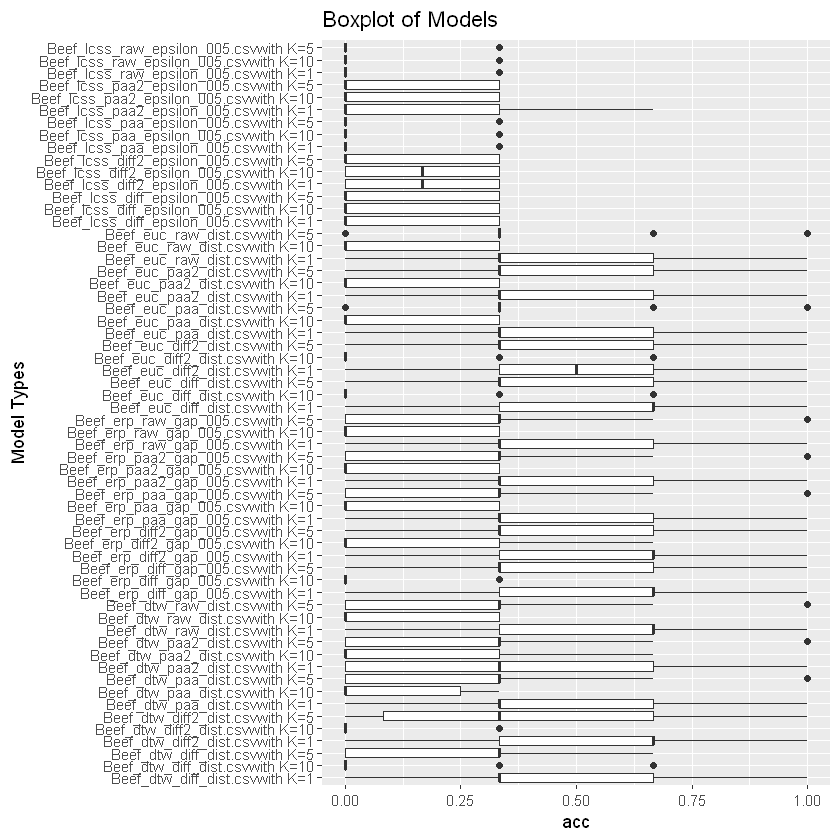

In [41]:
require(ggplot2)
ggplot(dataframe_result,aes(x=paste0(approach,'with K=',k), y=acc)) +
        geom_boxplot()+
        labs(title="Boxplot of Models")+
        xlab("Model Types")+
        coord_flip()

<a id="11"></a>
# Test Performance

Best performance is obtained when representation, distance, and k values are difference=1, Euclidean, and K=1 respectively.

In [42]:
traindata=as.matrix(fread(sprintf('%s%s/%s_TRAIN.txt',dataset_path, first_dataset,first_dataset)))
testdata=as.matrix(fread(sprintf('%s%s/%s_TEST.txt',dataset_path, first_dataset,first_dataset)))

In [43]:
all_dt=rbind(traindata, testdata)

In [44]:
allclass=all_dt[,1] 
all_dt=all_dt[,2:ncol(all_dt)]

In [45]:
test_indices_last=(nrow(all_dt)+1-nrow(testdata)):nrow(all_dt)

### Parameters

In [46]:
test_indices_last

[1] 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
[26] 56 57 58 59 60

In [47]:
last_k=1

## Distance Calculation

In [49]:
diff_test=difference_obtainer(all_dt,1)

In [50]:
dist_euc_diff_test=as.matrix(dist(diff_test))
diag(dist_euc_diff_test)=large_number

## Result of Test Dataset

In [51]:
last_result=nn_classify_cv(dist_euc_diff_test,allclass,test_indices_last,k=last_k)
accuracy=sum(allclass[test_indices_last]==last_result$prediction$predicted)/length(test_indices_last)
final_res=data.table(approach="Beef_euc_diff_dist.csv", k=last_k, acc=accuracy)

### Test Result

In [52]:
final_res

approach,k,acc
Beef_euc_diff_dist.csv,1,0.7


### Train Result

In [53]:
acc_res_ordered[1][,c("approach", "k", "avg_acc")]

approach,k,avg_acc
Beef_euc_diff_dist.csv,1,0.56


<a id="12"></a>
# Comments